In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wmb import cemba, mm10

from ALLCools.plot import *

In [2]:
mc_annot = cemba.get_mc_annot()
cluster_df = mc_annot.get_cluster_centroids_df("mc_all_tsne", "L4Region")
cluster_df["CellType"] = mc_annot["L4Region_cat_annot"].to_pandas()

In [3]:
m3c_annot = cemba.get_m3c_annot()
m3c_cluster_df = m3c_annot.get_cluster_centroids_df("mc_all_tsne", "L4Region")
m3c_cluster_df["CellType"] = m3c_annot["L4Region_cat_annot"].to_pandas()

In [4]:
cool_ds = cemba.get_cool_ds()


def get_loop_data(loop_id):
    loop_chrom, loop_bin1, loop_bin2 = loop_id.split("-")
    mat = cool_ds.fetch(loop_chrom)
    loop_data = (
        mat["real"]
        .sel(real_value_type="Q", bin1=int(loop_bin1), bin2=int(loop_bin2))
        .to_pandas()
    )
    sample_weights = mat['sample_weights'].to_pandas()
    return loop_data, sample_weights

In [9]:
dmr_ds = cemba.get_grouped_dmr_ds()
dmr_ds.coords["dmr_group"] = dmr_ds.get_index("dmr").map(lambda i: i.split(":")[0])

from functools import lru_cache

dmr_groups = dmr_ds["dmr_group"].values


@lru_cache()
def get_dmr_frac(dmr_group):
    return dmr_ds.sel(dmr=dmr_groups == dmr_group)["frac"].mean(dim="dmr").to_pandas()

In [6]:
gene_meta = mm10.get_gene_metadata()

In [7]:
#table = pd.read_hdf("TotalGeneDMRTF.NNZCorrRecords.All.hdf")
table = pd.read_csv('/data/CembaData/TotalGeneDMRTF.NNZCorrRecords.All.Filtered.csv', index_col = None)
table.sort_values("final-corr", inplace=True, ascending=False)
table["gene_name"] = table["gene"].map(mm10.gene_id_to_name)
table["tf_name"] = table["tf"].map(mm10.gene_id_to_name)

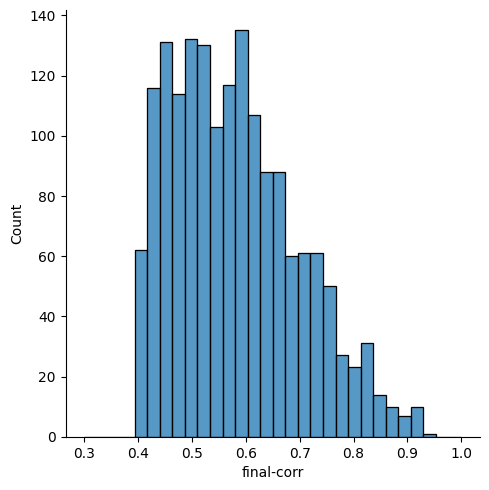

In [8]:
sns.displot(table.loc[table["tf-self-loop"], "final-corr"], bins=30, binrange=(0.3, 1))

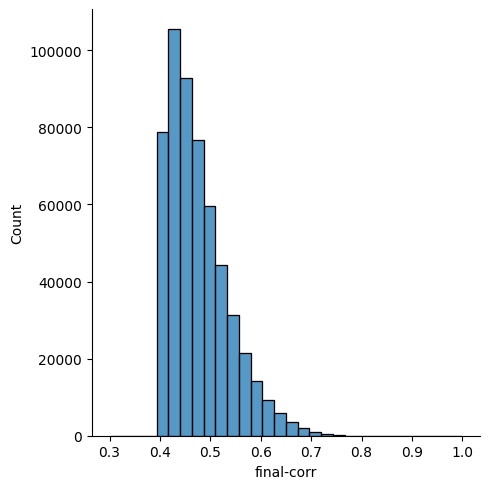

In [26]:
sns.displot(table.loc[~table["tf-self-loop"], "final-corr"], bins=30, binrange=(0.3, 1))

In [10]:
gene_records = table[~table["tf-self-loop"]]
tf_records = table[table["tf-self-loop"]]

In [18]:
gene_name = 'Pigk' 
dmr = 'chr3-152974381'

In [20]:
_info = gene_records[(gene_records['gene_name'] == gene_name) &(gene_records['dmr'] == dmr)]
_info = _info[_info['tf_name'] == 'Klf9']
_info

,gene,dmr,tf,loop,tf-self-loop,gene-dmr-corr,gene-dot-corr,tf-dmr-corr,gene-tf-corr,final-corr,gene_name,tf_name
243743,ENSMUSG00000039047,chr3-152974381,ENSMUSG00000033863,chr3-15280-15297,False,0.815918,0.505525,0.472412,0.3303,0.503722,Pigk,Klf9


In [13]:
gene_name = _info["gene_name"].values[0]
tf_name = _info["tf_name"].values[0]
dmr_group = _info["dmr"].values[0]
loop_id = _info["loop"].values[0]

In [14]:
gene_frac = cemba.get_mc_cluster_gene_frac(gene_name)
tf_frac = cemba.get_mc_cluster_gene_frac(tf_name)
dmr_frac = get_dmr_frac(dmr_group)
gene_rna = cemba.get_mc_cluster_gene_rna(gene_name)
tf_rna = cemba.get_mc_cluster_gene_rna(tf_name)

loop_data, sample_weights = get_loop_data(loop_id)

ct_loop_data = (loop_data * sample_weights).groupby(
    m3c_cluster_df["CellType"]
).sum() / sample_weights.groupby(m3c_cluster_df["CellType"]).sum()
cluster_ct_loop_data = m3c_cluster_df["CellType"].map(ct_loop_data)

Text(0.5, 1.0, 'chr3-15280-15297 m3C Q')

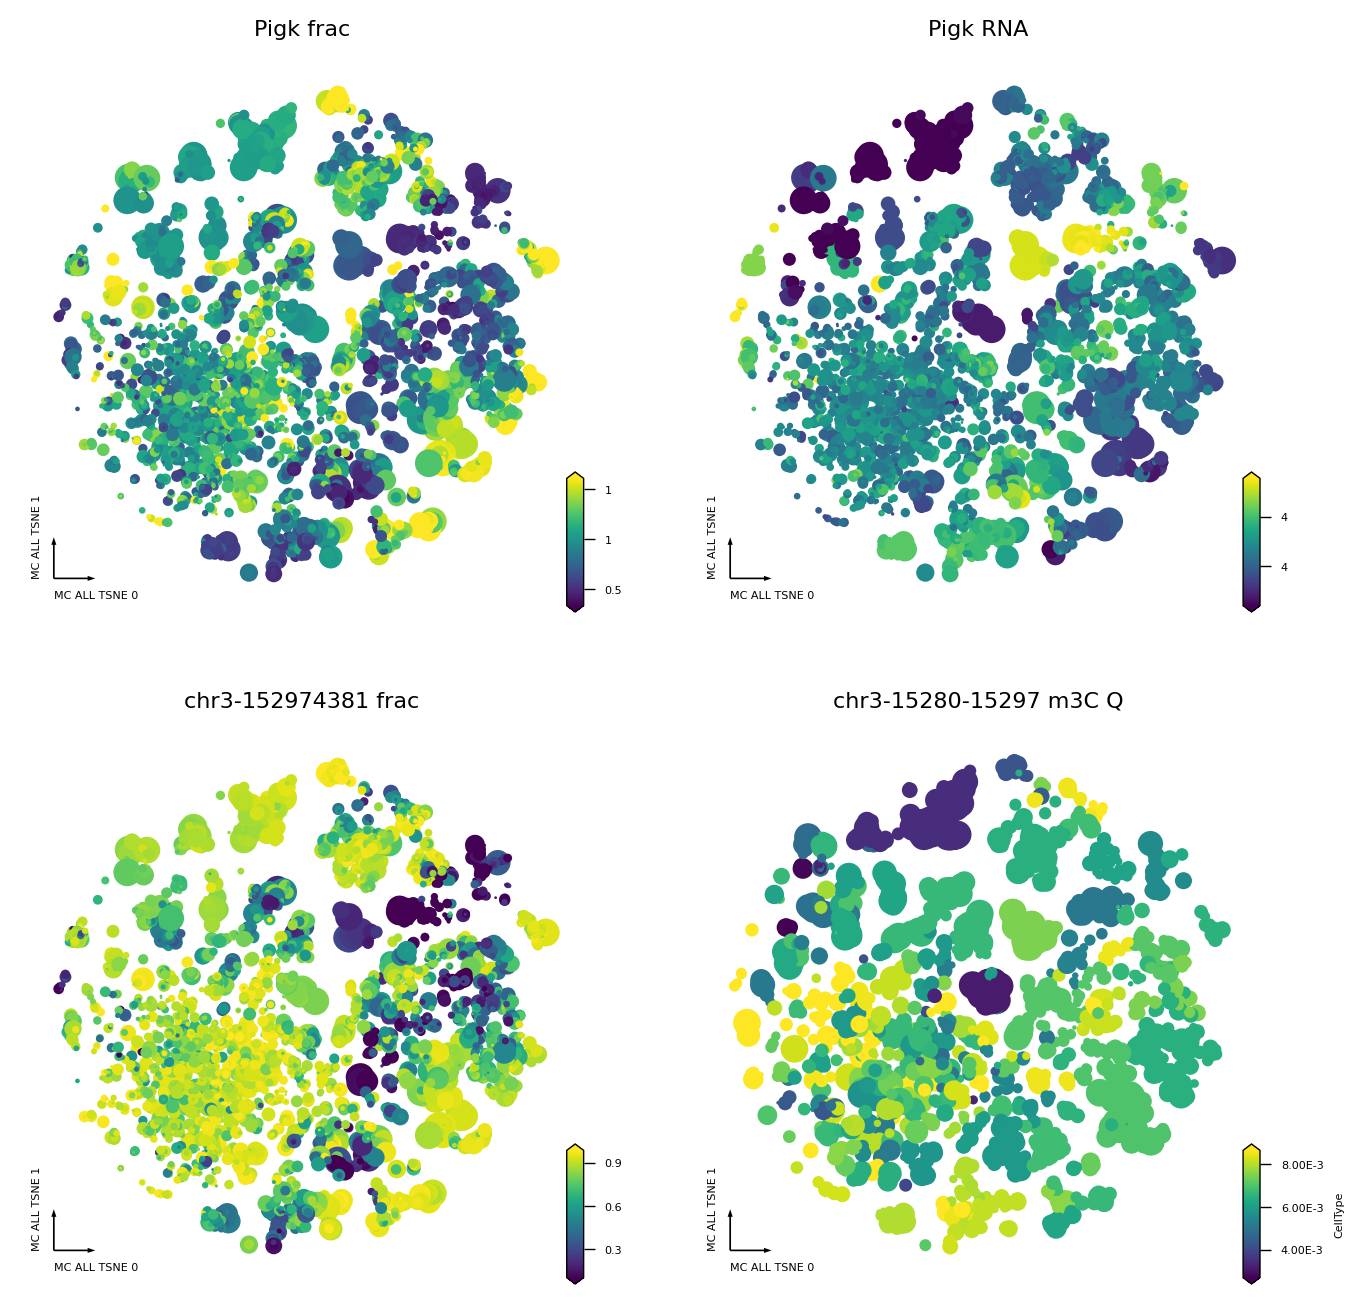

In [15]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=2, dpi=200)


ax = axes[0, 0]
continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=gene_frac,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{gene_name} frac", fontsize=8)

ax = axes[0, 1]
continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=gene_rna,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{gene_name} RNA", fontsize=8)

ax = axes[1, 0]
continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=dmr_frac,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{dmr_group} frac", fontsize=8)

ax = axes[1, 1]
continuous_scatter(
    ax=ax,
    data=m3c_cluster_df,
    coord_base="mc_all_tsne",
    hue=cluster_ct_loop_data,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(20, 200),
    # hue_norm=(0.023, 0.03)
)
ax.set_title(f"{loop_id} m3C Q", fontsize=8)

## get contact change during aging

Text(0.5, 1.0, 'Klf9 RNA')

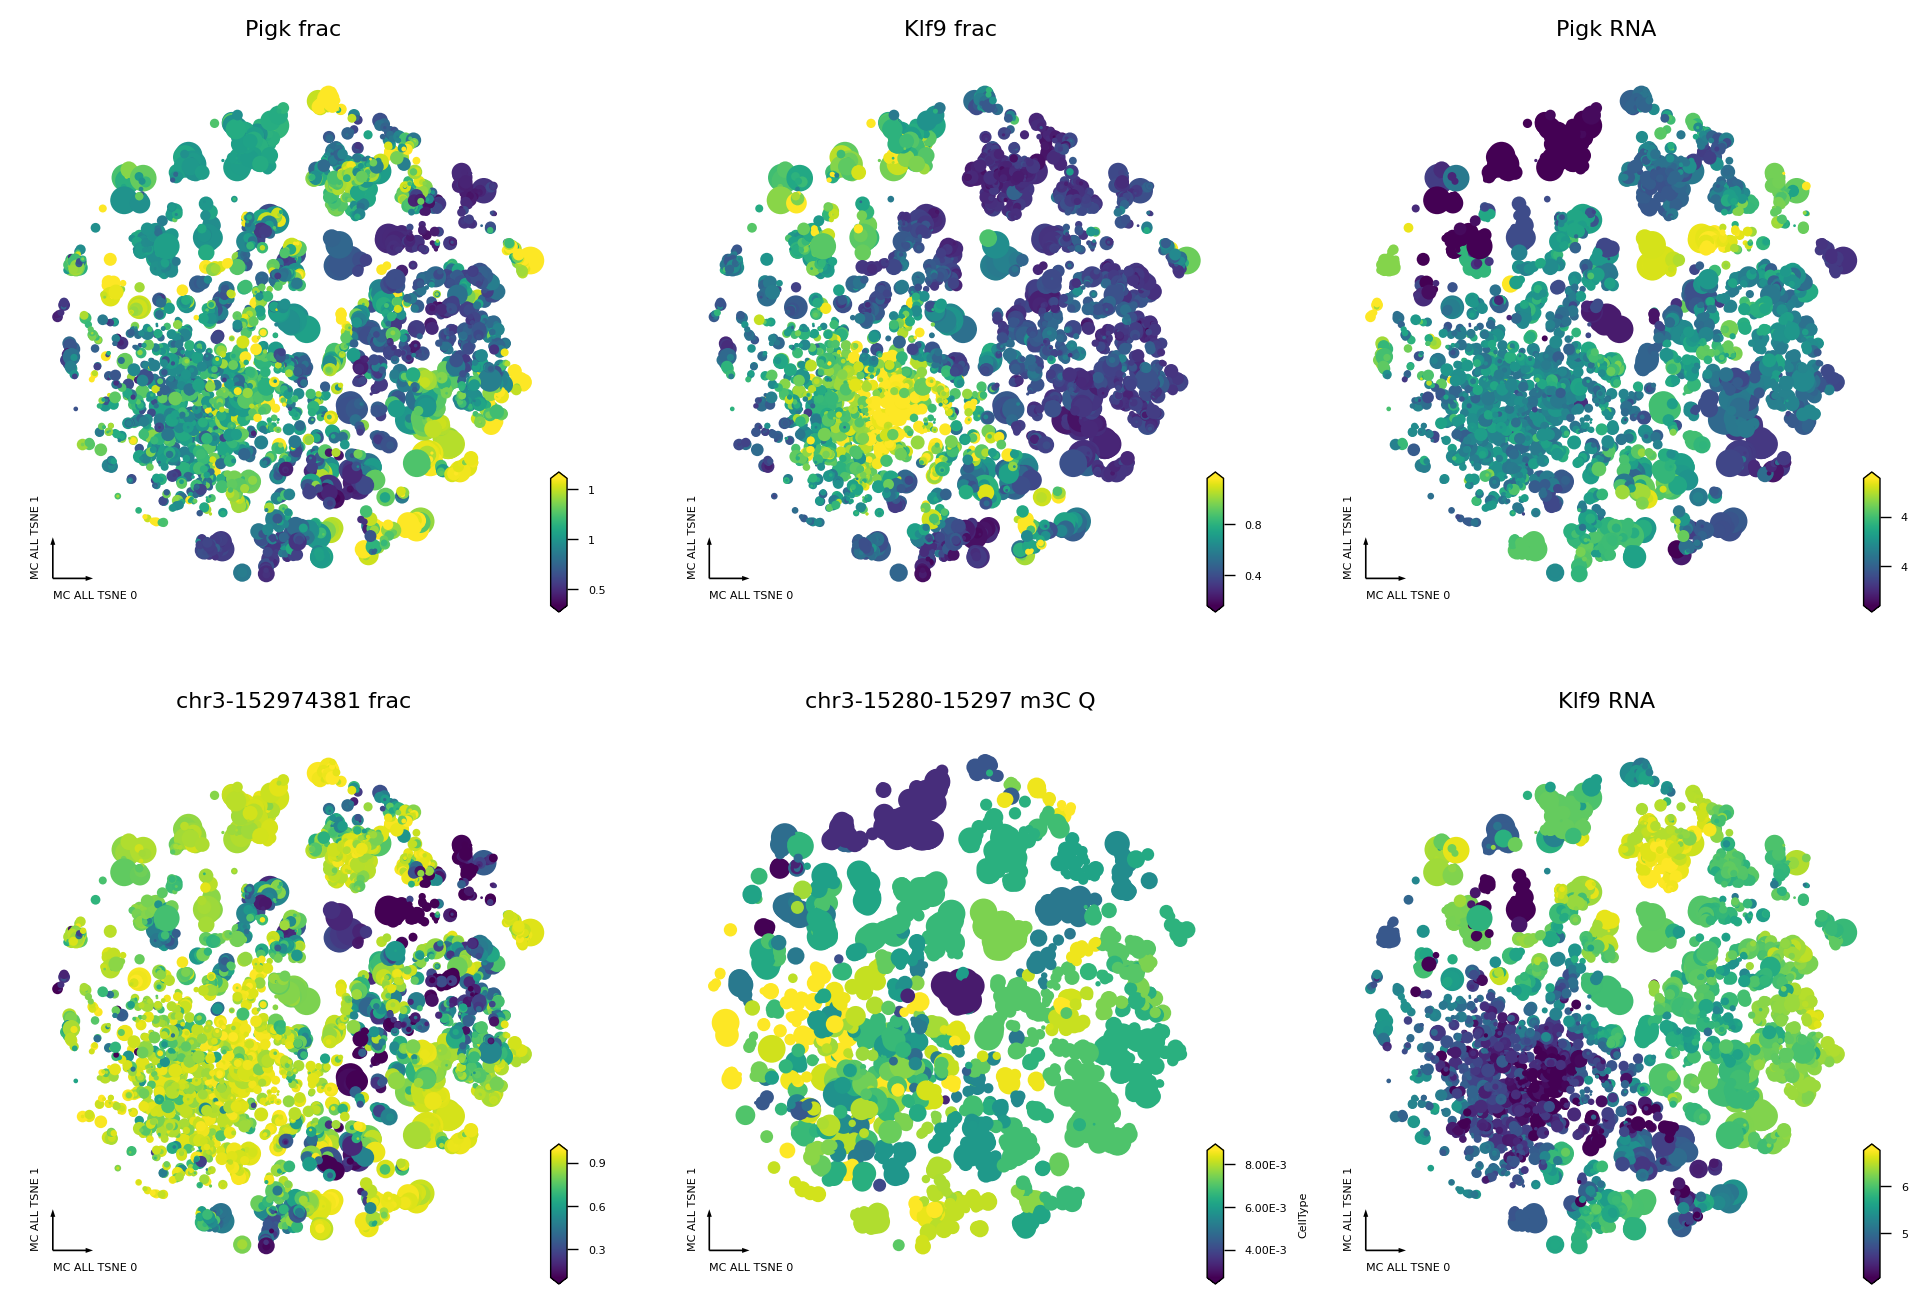

In [90]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, dpi=200)


ax = axes[0, 0]

continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=gene_frac,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{gene_name} frac", fontsize=8)

ax = axes[0, 1]

continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=tf_frac,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{tf_name} frac", fontsize=8)

ax = axes[1, 0]

continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=dmr_frac,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{dmr_group} frac", fontsize=8)

ax = axes[1, 1]
continuous_scatter(
    ax=ax,
    data=m3c_cluster_df,
    coord_base="mc_all_tsne",
    hue=cluster_ct_loop_data,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(20, 200),
    # hue_norm=(0.023, 0.03)
)
ax.set_title(f"{loop_id} m3C Q", fontsize=8)

ax = axes[0, 2]

continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=gene_rna,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{gene_name} RNA", fontsize=8)
ax = axes[1, 2]

continuous_scatter(
    ax=ax,
    data=cluster_df,
    coord_base="mc_all_tsne",
    hue=tf_rna,
    size="cell_counts",
    sizes=(1, 100),
    size_norm=(30, 300),
)
ax.set_title(f"{tf_name} RNA", fontsize=8)